# Training FDFL

In [19]:
import sys
import warnings
import time
import copy
import json
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import cvxpy as cp

from pyepo.model.opt import optModel
sys.path.insert(0, 'E:\\User\\Stevens\\MyRepo\\FDFL\\helper')
sys.path.insert(0, 'E:\\User\\Stevens\\MyRepo\\fold-opt-package\\fold_opt')

from myutil import *
from features import get_all_features

# Suppress warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


### Import and Process Data

Running with simpler model
Alpha = 0.5, 1.5, 2, 3

In [20]:
alpha, Q = 2, 1000

In [21]:
df = pd.read_csv('data/data.csv')
# fix random seed for reproducibility

# report statistics on this dataset
df = df.sample(n=5000, random_state=1)

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
#df['risk_score_t'] = df['risk_score_t'].apply(lambda x: 0.1 if x < 0.1 else x)
df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)


risk = df['risk_score_t'].values
risk = risk + 0.001 if 0 in risk else risk


feats = df[get_all_features(df)].values
gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.random.normal(1, 0.5, len(risk)).clip(0.1, 2)
race = df['race'].values

# transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

from sklearn.model_selection import train_test_split



### Define Alpha Fairness and Opt Solver

In [22]:
def AlphaFairness(util, alpha):
    if isinstance(util, torch.Tensor):
        util = util.detach().cpu().numpy() if isinstance(util, torch.Tensor) else util
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha) / (1-alpha))

def solve_optimization(gainF, risk, cost, alpha=alpha, Q=Q):
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost

    risk = risk.clip(0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")

    utils = cp.multiply(cp.multiply(gainF, risk), d)
    constraints = [d >= 0, cp.sum(cost * d) <= Q]

    if alpha == 'inf':
        t = cp.Variable()
        objective = cp.Maximize(t)
        constraints.append(utils >= t)
    elif alpha == 1:
        objective = cp.Maximize(cp.sum(cp.log(utils)))
    elif alpha == 0:
        objective = cp.Maximize(cp.sum(utils))
    else:
        objective = cp.Maximize(cp.sum(utils**(1-alpha)) / (1-alpha))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=False, warm_start=True, mosek_params={'MSK_IPAR_LOG': 1})

    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")

    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)

    return optimal_decision, optimal_value


### Closed Form Solution and Gradients

In [23]:
import numpy as np

def solve_closed_form(g, r, c, alpha=alpha, Q=Q):

    g = g.detach().cpu().numpy() if isinstance(g, torch.Tensor) else g
    r = r.detach().cpu().numpy() if isinstance(r, torch.Tensor) else r
    c = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else c
    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
    obj = AlphaFairness(d_star_closed * utility, alpha)
        
    return d_star_closed, obj

def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    if alpha == 1:
        S = np.sum(c / (r * g))

    if alpha == 0:
        # Utilitarian case: Allocate everything to the individual with the highest ratio
        ratios = (r * g) / c
        i_star = np.argmax(ratios)
        # Gradient is Q * g_i / c_i at the allocated index, zero elsewhere
        gradient[i_star, i_star] = Q * g[i_star] / c[i_star]
        return gradient

    elif alpha == 'inf':
        # Maximin case
        n = len(c)
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar

        # Compute d_star
        d_star, _ = solve_closed_form(g,r,c, alpha='inf', Q=Q)  # Shape: (n,)

        # Initialize gradient matrix
        gradient = np.zeros((n, n))

        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_i = -d_i*/r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star[i] / r[i] - (d_star[i] * c[i]) / (r[i] * g[i] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient

    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star, _ = solve_closed_form(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient

### Visualization

In [24]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log, fairness_log=None):
    if fairness_log is not None:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Training Loss Curve", fontsize=16)
    ax1.grid(True, alpha=0.3)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)
    ax2.grid(True, alpha=0.3)

    # Plot MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)
    ax3.grid(True, alpha=0.3)

    # Plot fairness log if provided
    if fairness_log is not None:
        ax4.plot(fairness_log, color="green", lw=2)
        ax4.tick_params(axis="both", which="major", labelsize=12)
        ax4.set_xlabel("Iters", fontsize=16)
        ax4.set_ylabel("Fairness", fontsize=16)
        ax4.set_title("Learning Curve (Fairness)", fontsize=16)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [25]:
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()
        self.race = torch.from_numpy(race).float()
        self.optmodel = optmodel

        # Solve for w*, z* using separate risk and gainF # Ensure a separate instance
        self.w_star, self.z_star = self.optmodel(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.race, self.w_star, self.z_star


# Prediction Stage

In [26]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Softplus()
        )
            
                    
    def forward(self, x):
        return self.model(x).squeeze(-1)
    
# class FairRiskPredictor(nn.Module):
#     def __init__(self, input_dim, dropout_rate=0.1):
#         super().__init__()
#         self.model = nn.Sequential(
#             # First layer with batch normalization
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
            
#             # Output layer
#             nn.Linear(64, 1),
#             nn.Softplus()
#         )
            
#     def forward(self, x):
#         return self.model(x).squeeze(-1)

# Calculate Regret

Normalizaed Regret

In [27]:
def regret(predmodel, optmodel, dataloader, alpha=alpha, Q=Q):
    predmodel.eval()
    feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(dataloader))

    if torch.cuda.is_available():
        feats, risk, gainF, cost, race, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), race.cuda(), opt_sol.cuda(), opt_val.cuda()

    with torch.no_grad():
        pred_risk = predmodel(feats)

    risk = risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.detach().to('cpu').numpy().flatten()
    pred_risk = pred_risk.clip(min=0.001)
    gainF = gainF.detach().to('cpu').numpy().flatten()
    cost = cost.detach().to('cpu').numpy().flatten()
    pred_sol, _ = optmodel(gainF, pred_risk, cost, alpha, Q)
        
    pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)

    normalized_regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)
    predmodel.train()
    return normalized_regret

### Cvxpylayer loss

In [ ]:
from cvxpylayers.torch import CvxpyLayer

class FairRegretLossFunction0(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_sol, true_obj, Q, alpha, race, lambda_fairness, grad_method):
        ctx.grad_method = grad_method
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)

        pred_r_np, true_r_np, cost_np, gainF_np = [x.detach().cpu().numpy() for x in [pred_r, true_r, cost, gainF]]
        
        if grad_method == 'cvxpylayer':
            # Create a differentiable parameter tensor properly:
            aux_param_value = (gainF_np.reshape(-1) * pred_r_np.reshape(-1))
            aux_param_torch = torch.from_numpy(aux_param_value).float().to(pred_r.device)
            aux_param_torch.requires_grad_(True)
            
            # Define the CVXPY problem (with shapes matching aux_param_value)
            n = aux_param_value.size  # or aux_param_value.shape[0] if 1D
            aux_x = cp.Variable(n)
            aux_param = cp.Parameter(n, nonneg=True)
            objective_expr = (1/(1 - alpha)) * cp.sum(cp.power(cp.multiply(aux_param, aux_x), 1 - alpha))
            aux_obj = cp.Maximize(objective_expr)
            aux_constr = [cp.sum(cp.multiply(cost, aux_x)) <= Q, aux_x >= 0]
            aux_prob = cp.Problem(aux_obj, aux_constr)
            
            # Ensure the problem is DPP.
            assert aux_prob.is_dpp()
            
            # Set the parameter value.
            aux_param.value = aux_param_value
            
            # Create the CVXPY layer.
            cvxpylayer = CvxpyLayer(aux_prob, parameters=[aux_param], variables=[aux_x])
            
            # Forward pass through the CVXPY layer.
            aux_sol, = cvxpylayer(aux_param_torch)
            
            # Save for backward.
            ctx.aux_param_torch = aux_param_torch
            ctx.cvxpylayer = cvxpylayer
            ctx.aux_sol = aux_sol


        

        for i in range(batch_size):
            sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj
        
        group0_mean, group1_mean = [pred_r[race == g].mean() if (race == g).sum() > 0 else 0 for g in [0, 1]]
        fairness_loss = lambda_fairness * torch.abs(group0_mean - group1_mean)
        
        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_sol, true_obj, race)
        ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.losses, ctx.group0_mean, ctx.group1_mean, ctx.n0, ctx.n1 = \
            optmodel, Q, alpha, lambda_fairness, losses, group0_mean, group1_mean, (race == 0).sum(), (race == 1).sum()

        return (losses.mean() + fairness_loss).to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_sol, true_obj, race = ctx.saved_tensors
        optmodel, Q, alpha, lambda_fairness, group0_mean, group1_mean, n0, n1, grad_method = \
            ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.group0_mean, ctx.group1_mean, ctx.n0, ctx.n1, ctx.grad_method
        
        grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)
        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        for i in range(batch_size):
            pred_r_np, cost_np, true_r_np, gainF_np, true_sol_np = [x[i].detach().cpu().numpy() for x in [pred_r, cost, true_r, gainF, true_sol]]
            grad_l_d_i = -torch.tensor(grad_l_d[i], device=pred_r.device, requires_grad=True)

            if grad_method == 'closed_form':
                closed_grad_d_r = torch.tensor(compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q), device=pred_r.device, requires_grad=True)
                grad_pred_r[i] = grad_l_d_i @ closed_grad_d_r

            elif grad_method in ['finite_difference_1', 'finite_difference_2']:
                epsilon = 1e-6
                ptb_r = pred_r_np.copy()
                for k in range(len(ptb_r)):
                    ptb_r[k] += epsilon
                    sol_plus, obj_plus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    ptb_r[k] -= 2 * epsilon
                    sol_minus, obj_minus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    
                    if grad_method == 'finite_difference_1':
                        # Correct central difference for sol
                        ptb_grad = (sol_plus - sol_minus) / (2 * epsilon)
                        grad_pred_r[i][k] = grad_l_d_i @ torch.tensor(ptb_grad, device=pred_r.device)
                    
                    elif grad_method == 'finite_difference_2':
                        # Correct central difference for obj
                        ptb_grad = (obj_plus - obj_minus) / (2 * epsilon)
                        grad_pred_r[i][k] = ptb_grad
            # elif grad_method == 'cvxpylayer':
            #     aux_param_torch = ctx.aux_param_torch
            #     aux_sol = ctx.aux_sol
                
                
            #     # Debug: Check that param_val and aux_sol are connected.
            #     print("aux_sol.requires_grad:", aux_sol.requires_grad)
                
            #     # Compute the gradient of loss_cvx with respect to param_val.
            #     grad_aux, = torch.autograd.grad(aux_sol.sum(), aux_param_torch,
            #                                     retain_graph=True, create_graph=True)
                
            #     grad_pred_r[i] = grad_aux * gainF

            #     closed_grad_d_r = torch.tensor(compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q), device=pred_r.device, requires_grad=True)
            #     testing_grad = grad_l_d_i @ closed_grad_d_r
            #     print('DONE')
            #     print("Testing gradient:", testing_grad)
            #     print("CVXPYLayer gradient:", grad_aux)


            if group0_mean != group1_mean:
                for j, race_val in enumerate(race[i]):
                    if race_val == 0 and n0 > 0:
                        grad_pred_r[i][j] += lambda_fairness * torch.sign(group0_mean - group1_mean) / n0
                    elif race_val == 1 and n1 > 0:
                        grad_pred_r[i][j] -= lambda_fairness * torch.sign(group0_mean - group1_mean) / n1

        return None, None, None, grad_output * grad_pred_r, None, None, None, None, None, None, None, None

class FairRegretLoss0(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0, grad_method='closed_form'):
        super(FairRegretLoss0, self).__init__()
        self.optmodel, self.Q, self.alpha, self.lambda_fairness, self.grad_method = optmodel, Q, alpha, lambda_fairness, grad_method

    def forward(self, gainF, pred_r, true_r, cost, true_sol, true_obj, race):
        return FairRegretLossFunction0.apply(self.optmodel, gainF, cost, pred_r, true_r, true_sol, true_obj, self.Q, self.alpha, race, self.lambda_fairness, self.grad_method)


# Fold OPT


In [29]:
from fold_opt import *
from GMRES import *

# TODO HERE

# Fair Regret Loss nn.Module

In [30]:
class FairRegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_sol, true_obj, Q, alpha, race, lambda_fairness, grad_method):
        ctx.grad_method = grad_method
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np, true_r_np, cost_np, gainF_np = [x.detach().cpu().numpy() for x in [pred_r, true_r, cost, gainF]]
        
        for i in range(batch_size):
            sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj
        

        # Compute group-wise MSE
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        n0 = group0_mask.sum().item()
        n1 = group1_mask.sum().item()
        if n0 > 0:
            mse0 = torch.mean((pred_r[group0_mask] - true_r[group0_mask]) ** 2)
        else:
            mse0 = torch.tensor(0.0, device=pred_r.device)
        
        if n1 > 0:
            mse1 = torch.mean((pred_r[group1_mask] - true_r[group1_mask]) ** 2)
        else:
            mse1 = torch.tensor(0.0, device=pred_r.device)
        
        fairness_loss = lambda_fairness * torch.abs(mse0 - mse1)
        mse_diff_sign = torch.tensor(mse0 > mse1, dtype=torch.float32, device=pred_r.device)

        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_sol, true_obj, race)
        ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.losses, ctx.group0_mask, ctx.group1_mask, ctx.n0, ctx.n1 = \
            optmodel, Q, alpha, lambda_fairness, losses, group0_mask, group1_mask, torch.tensor(n0, device=pred_r.device), torch.tensor(n1, device=pred_r.device)
        ctx.mse_diff_sign = mse_diff_sign
        return (losses.mean() + fairness_loss).to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        if not hasattr(ctx, "fold_cache"):
            ctx.fold_cache = {}
        gainF, pred_r, true_r, cost, true_sol, true_obj, race = ctx.saved_tensors
        optmodel, Q, alpha, lambda_fairness, group0_mask, group1_mask, n0, n1, grad_method = \
            ctx.optmodel, ctx.Q, ctx.alpha, ctx.lambda_fairness, ctx.group0_mask, ctx.group1_mask, ctx.n0, ctx.n1, ctx.grad_method
        mse_diff_sign = ctx.mse_diff_sign
        group0_mask, group1_mask = ctx.group0_mask, ctx.group1_mask
        grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)
        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        # grad of fairness
        grad_fairness = torch.zeros_like(pred_r)
        sign = torch.sign(mse_diff_sign*2-1)

        for i in range(batch_size):
            pred_r_np, cost_np, true_r_np, gainF_np, true_sol_np = [x[i].detach().cpu().numpy() for x in [pred_r, cost, true_r, gainF, true_sol]]
            grad_l_d_i = -torch.tensor(grad_l_d[i], device=pred_r.device, requires_grad=True)

            if grad_method == 'closed_form':
                closed_grad_d_r = torch.tensor(compute_gradient_closed_form(gainF_np, pred_r_np, cost_np, alpha, Q), device=pred_r.device, requires_grad=True)
                grad_pred_r[i] = grad_l_d_i @ closed_grad_d_r

            elif grad_method == 'fold_opt':
                key = tuple(gainF_np)
                if key not in ctx.fold_cache:
                    ctx.fold_cache[key] = make_foldopt_layer(gainF_np, cost_np, Q, alpha,n_iter=200, lr=5e-2).to(pred_r.device)
                layer = ctx.fold_cache[key]

                r_var = pred_r[i:i+1].detach().requires_grad_(True)
                vjp, = torch.autograd.grad(
                         outputs=true_sol,
                         inputs=r_var,
                         grad_outputs=grad_l_d_i.unsqueeze(0),
                         retain_graph=False)


            elif grad_method in ['finite_difference_1', 'finite_difference_2']:
                epsilon = 1e-7
                ptb_r = pred_r_np.copy()
                for k in range(len(ptb_r)):
                    ptb_r[k] += epsilon
                    sol_plus, obj_plus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    ptb_r[k] -= 2 * epsilon
                    sol_minus, obj_minus = optmodel(gainF_np, ptb_r, cost_np, alpha, Q)
                    
                    if grad_method == 'finite_difference_1':
                        # Correct central difference for sol
                        ptb_grad = (sol_plus - sol_minus) / (2 * epsilon)
                        grad_pred_r[i][k] = grad_l_d_i @ torch.tensor(ptb_grad, device=pred_r.device)
                    
                    elif grad_method == 'finite_difference_2':
                        # Correct central difference for obj
                        ptb_grad = (obj_plus - obj_minus) / (2 * epsilon)
                        grad_pred_r[i][k] = ptb_grad

                g0 = (race[i] == 0)
                g1 = (race[i] == 1)
                if g0.any():
                    grad_fairness[i, g0]  =  2 * (pred_r[i, g0] - true_r[i, g0]) / g0.sum()
                if g1.any():
                    grad_fairness[i, g1]  = -2 * (pred_r[i, g1] - true_r[i, g1]) / g1.sum()
                grad_fairness[i] *= lambda_fairness * torch.sign(mse_diff_sign)


            grad_pred_r[i] += grad_fairness[i]
        

        return None, None, None, grad_output * grad_pred_r, None, None, None, None, None, None, None, None

class FairRegretLoss(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0, grad_method='closed_form'):
        super(FairRegretLoss, self).__init__()
        self.optmodel, self.Q, self.alpha, self.lambda_fairness, self.grad_method = optmodel, Q, alpha, lambda_fairness, grad_method

    def forward(self, gainF, pred_r, true_r, cost, true_sol, true_obj, race):
        return FairRegretLossFunction.apply(self.optmodel, gainF, cost, pred_r, true_r, true_sol, true_obj, self.Q, self.alpha, race, self.lambda_fairness, self.grad_method)


### MSE with Accruacy Parity

In [31]:
class FairMSELoss(nn.Module):
    def __init__(self, lambda_fairness=1.0):
        super(FairMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_fairness = lambda_fairness

    def forward(self, pred, target, race):
        mse_loss = self.mse(pred, target)
        group_means = [pred[race == g].mean() if (race == g).sum() > 0 else 0 for g in [0, 1]]
        fairness_loss = torch.abs(group_means[0] - group_means[1])
        return mse_loss + self.lambda_fairness * fairness_loss


# Trainning 

In [32]:
# Setup training parameters

optmodel = solve_closed_form

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, df['race'].values, test_size=0.5, random_state=2
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

dataset_train = optDataset(optmodel, feats_train, risk_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
dataset_test = optDataset(optmodel, feats_test, risk_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)
# save the initial model
# torch.save(predmodel.state_dict(), 'initial_model.pth')
# load the initial model

Train size: 2500
Test size: 2500


FairRiskPredictor(
  (model): Sequential(
    (0): Linear(in_features=149, out_features=1, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [33]:
def AlphaFairnessTorch(util, alpha):
    # convert to torch tensor if not already
    if not isinstance(util, torch.Tensor):
        util = torch.tensor(util, dtype=torch.float32)
    if alpha == 1:
        return torch.sum(torch.log(util))
    elif alpha == 0:
        return torch.sum(util)
    elif alpha == 'inf':
        return torch.min(util)
    else:
        return torch.sum(util**(1-alpha) / (1-alpha))

In [34]:
# Define cvxpy model
n = risk_train.shape[0]
decision_var = cp.Variable(n)
p = cp.Parameter(n, nonneg=True)
# Q is defined

# Define the CVXPY optimization problem
obj = cp.Maximize((1 / (1 - alpha)) * cp.sum(cp.power(cp.multiply(p, decision_var), 1 - alpha)))
constr = [cp.sum(cp.multiply(cost_train, decision_var)) <= Q, decision_var >= 0]

problem = cp.Problem(obj, constr)

# Create CVXPY layer
cvxpylayer = CvxpyLayer(problem, parameters=[p], variables=[decision_var])



In [35]:
def trainFairModel(predmodel, optmodel, loader_train, loader_test, lambda_fairness, 
                num_epochs=10, initial_lr=1e-3, weight_decay=1e-4, alpha=alpha, Q=Q, 
                dfl=True, grad_method='closed_form', scheduler_patience=5, 
                scheduler_factor=0.5, min_lr=1e-6):
    """
    Enhanced training function with adaptive learning rate and weight decay
    
    Args:
        predmodel: Prediction model to train
        optmodel: Optimization model
        loader_train: Training data loader
        loader_test: Test data loader
        lambda_fairness: Fairness penalty coefficient
        num_epochs: Number of training epochs
        initial_lr: Initial learning rate
        weight_decay: L2 regularization factor
        alpha: Alpha parameter for fairness
        Q: Q parameter
        dfl: Whether to use DFL loss
        grad_method: Gradient computation method
        scheduler_patience: Number of epochs to wait before reducing LR
        scheduler_factor: Factor by which to reduce LR
        min_lr: Minimum learning rate
    """
    # Initialize optimizer with weight decay
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=initial_lr, weight_decay=weight_decay)
    
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=scheduler_factor,
        patience=scheduler_patience,
        verbose=True,
        min_lr=min_lr
    )
    
    loss_func = FairRegretLoss(optmodel, Q=Q, alpha=alpha, lambda_fairness=lambda_fairness, grad_method=grad_method)
    fair_mse_loss_func = FairMSELoss(lambda_fairness=lambda_fairness)
    mse_loss_func = nn.MSELoss()

    train_loss_log = []
    test_regret_log = []
    test_mse_log = []
    test_fair_log = []
    best_regret = float('inf')
    best_model_state = None
    elapsed = 0

    init_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
    print(f'Initial test regret: {float(init_regret):.4f}')
    # print(f'Initial learning rate: {initial_lr}')



    for epoch in range(num_epochs):
        tick = time.time()
        predmodel.train()
        
        # Get batch data
        feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(loader_train))
        if torch.cuda.is_available():
            feats, risk, gainF, cost, race, opt_sol, opt_val = [
                x.cuda() for x in [feats, risk, gainF, cost, race, opt_sol, opt_val]
            ]


        # Forward pass

        pred_risk = predmodel(feats).clip(min=0.001)


        if grad_method == 'cvxpylayer':
                
            true_util = (gainF * risk * opt_sol)
            opt_val = AlphaFairnessTorch(true_util, alpha)

            optimizer.zero_grad()
            # Compute the CVXPY layer output
            param = (gainF * pred_risk).squeeze(0)
            
            pred_sol, = cvxpylayer(param)
            pred_util = gainF * risk * pred_sol
            if alpha == 1:
                pred_obj =  torch.sum(torch.log(pred_util))
            elif alpha == 0:
                pred_obj = torch.sum(pred_util)
            elif alpha == 'inf':
                pred_obj = torch.min(pred_util)
            else:
                pred_obj = torch.sum(pred_util**(1-alpha) / (1-alpha))

            loss = (opt_val - pred_obj) / (abs(opt_val) + 1e-7) 

            group0_mask = (race == 0)
            group1_mask = (race == 1)
            mse0 = torch.mean((pred_risk[group0_mask] - risk[group0_mask]) ** 2)
            mse1 = torch.mean((pred_risk[group1_mask] - risk[group1_mask]) ** 2)
            fairness_reg = torch.abs(mse0 - mse1)
            loss += lambda_fairness * fairness_reg
            loss.backward()
            optimizer.step()

        else:
            # Compute losses
            loss = loss_func(gainF, pred_risk, risk, cost, opt_sol, opt_val, race)

            fair_mse_loss = fair_mse_loss_func(pred_risk, risk, race)

            # Backward pass
            optimizer.zero_grad()
            (loss if dfl else fair_mse_loss).backward()
            optimizer.step()

        mse_loss = mse_loss_func(pred_risk, risk)

        # Compute fairness metric (accuracy parity: difference in MSE between groups)
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        n0 = group0_mask.sum().item()
        n1 = group1_mask.sum().item()
        
        if n0 > 0:
            mse0 = torch.mean((pred_risk[group0_mask] - risk[group0_mask]) ** 2).item()
        else:
            mse0 = 0.0
        
        if n1 > 0:
            mse1 = torch.mean((pred_risk[group1_mask] - risk[group1_mask]) ** 2).item()
        else:
            mse1 = 0.0
        fairness_metric = abs(mse0 - mse1)
        # Calculate test regret
        current_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        
        # Save best model
        if current_regret < best_regret:
            best_regret = current_regret
            best_model_state = copy.deepcopy(predmodel.state_dict())

        # Update learning rate
        scheduler.step(current_regret)
        current_lr = optimizer.param_groups[0]['lr']

        # Log metrics
        elapsed += time.time() - tick

        # convert to numpy for logging if they are tensor
        if isinstance(loss, torch.Tensor):
            loss = loss.item()
        if isinstance(mse_loss, torch.Tensor):
            mse_loss = mse_loss.item()
        if isinstance(fairness_metric, torch.Tensor):
            fairness_metric = fairness_metric.item()
        if isinstance(current_regret, torch.Tensor):
            current_regret = current_regret.item()
        

        train_loss_log.append(float(loss))
        test_mse_log.append(float(mse_loss))
        test_fair_log.append(fairness_metric)
        test_regret_log.append(current_regret)

        # if epoch % 20 == 0:
        #     print(f"Epoch {epoch+1:2}, LR:{current_lr:.2e}, MSE:{float(mse_loss):.4f}, "
        #           f"Loss:{float(loss):.4f}, Fairness:{fairness_metric:.4f}, "
        #           f"Regret:{current_regret:.4f}%, Time:{elapsed:.2f}s")

        # Early stopping check
        if current_lr <= min_lr:
            # print(f"Learning rate {current_lr} below minimum threshold. Stopping early.")
            break

    # Restore best model
    if best_model_state is not None:
        predmodel.load_state_dict(best_model_state)
        # print(f"Restored best model with regret: {best_regret:.4f}")
    
    predmodel.eval()
    return test_regret_log, train_loss_log, test_mse_log, test_fair_log

# Test FOLD-OPT

## Training Params

### Define cvxpylayer

# Test the training pipeline

In [36]:
# predmodel = FairRiskPredictor(feats_train.shape[1])
# predmodel.to(device)

# test_regret_log, train_loss_log, test_mse_log, test_fair_log = trainFairModel(
#     predmodel=predmodel,
#     optmodel=solve_closed_form,
#     loader_train=dataloader_train,
#     loader_test=dataloader_test,
#     lambda_fairness=0,
#     num_epochs=10,
#     initial_lr=2e-3,
#     weight_decay=1e-4,
#     scheduler_patience=10,
#     scheduler_factor=0.5,
#     min_lr=1e-5,
#     dfl=True,
#     grad_method='cvxpylayer',
# )

# train_loss_log_values = [loss for loss in train_loss_log]
# test_regret_log_values = [regret for regret in test_regret_log]
# mse_loss_log_values = [mse for mse in test_mse_log]
# fairness_log_values = [fair for fair in test_fair_log]


# visLearningCurve(
#     train_loss_log_values,
#     test_regret_log_values,
#     mse_loss_log_values,
#     fairness_log_values
# )

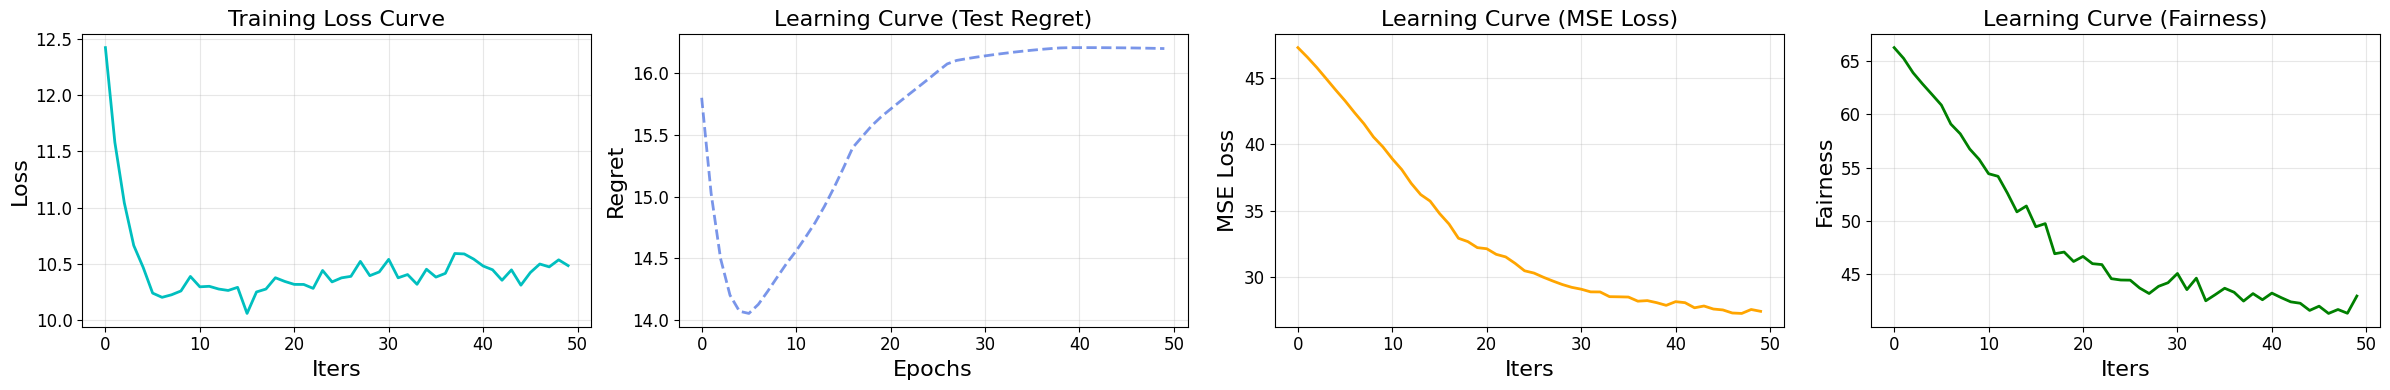

In [37]:
# import optuna

# def objective(trial):
#     # Define the search space
#     num_epochs = trial.suggest_int("num_epochs", 20, 100)
#     initial_lr = trial.suggest_loguniform("initial_lr", 1e-5, 1e-2)
#     weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
#     scheduler_patience = trial.suggest_int("scheduler_patience", 5, 20)
#     scheduler_factor = trial.suggest_float("scheduler_factor", 0.1, 0.9)
#     min_lr = trial.suggest_loguniform("min_lr", 1e-6, 1e-4)
    
#     # Train the model
#     test_regret_log, _, test_mse_log, _ = trainFairModel(
#         predmodel=predmodel,
#         optmodel=solve_closed_form,
#         loader_train=dataloader_train,
#         loader_test=dataloader_test,
#         lambda_fairness=0,
#         num_epochs=num_epochs,
#         dfl=True,
#         initial_lr=initial_lr,
#         weight_decay=weight_decay,
#         scheduler_patience=scheduler_patience,
#         scheduler_factor=scheduler_factor,
#         min_lr=min_lr
#     )
    
#     # Return the metric to minimize
#     return min(test_regret_log)

# # Run the study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# # Print best hyperparameters
# print("Best hyperparameters:", study.best_params)


# run_multiple_trials

In [38]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def run_multiple_trials(optmodel, feats, gainF, risk, cost, df, n_trials=10, test_size=0.5, 
                       lambda_fairness=0, num_epochs=50, initial_lr=5e-3, 
                       weight_decay=1e-4, scheduler_patience=5, scheduler_factor=0.5, 
                       min_lr=1e-6, alpha=0.5, Q=1000, dfl=False, grad_method='closed_form', device='cuda'):
    """
    Run multiple trials with different random splits and return average results
    """
    # Initialize lists to store results from all trials
    all_train_loss = []
    all_test_regret = []
    all_test_mse = []
    all_test_fair = []
    all_train_time = []

    total_time = time.time()
    
    for trial in range(n_trials):
        print(f"\nRunning trial {trial + 1}/{n_trials}")
        trial_start_time = time.time()
        
        # Perform train-test split with different random state for each trial
        split_vars = train_test_split(
            feats, gainF, risk, cost, df['race'].values,
            test_size=test_size, random_state=trial
        )
        
        (feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test,
         cost_train, cost_test, race_train, race_test) = split_vars
        
        # Create datasets
        dataset_train = optDataset(optmodel, feats_train, risk_train, 
                                 gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
        dataset_test = optDataset(optmodel, feats_test, risk_test, 
                                gainF_test, cost_test, race_test, alpha=alpha, Q=Q)
        
        # Create dataloaders
        dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
        dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)
        
        # Initialize model
        predmodel = FairRiskPredictor(feats_train.shape[1])
        predmodel.to(device) if device == 'cuda' else predmodel.cpu()
        
        # Train model
        results = trainFairModel(
            predmodel=predmodel,
            optmodel=optmodel,
            loader_train=dataloader_train,
            loader_test=dataloader_test,
            lambda_fairness=lambda_fairness,
            num_epochs=num_epochs,
            initial_lr=initial_lr,
            weight_decay=weight_decay,
            alpha=alpha,
            Q=Q,
            dfl=dfl,
            grad_method=grad_method,
            scheduler_patience=scheduler_patience,
            scheduler_factor=scheduler_factor,
            min_lr=min_lr
        )
        
        test_regret_log, train_loss_log, test_mse_log, test_fair_log = results
        
        # Store results
        all_train_loss.append(train_loss_log)
        all_test_regret.append(test_regret_log)
        all_test_mse.append(test_mse_log)
        all_test_fair.append(test_fair_log)

        trial_time = time.time() - trial_start_time
        all_train_time.append(trial_time)

    total_times = time.time() - total_time
    mean_time = np.mean(all_train_time)
    std_time = np.std(all_train_time)

    print(f"\nAll trials completed in {total_times:.2f} seconds")
    print(f"Mean trial time: {mean_time:.2f} ± {std_time:.2f} seconds")

    # Convert to numpy arrays for easier manipulation
    all_train_loss = np.array(all_train_loss)
    all_test_regret = np.array(all_test_regret)
    all_test_mse = np.array(all_test_mse)
    all_test_fair = np.array(all_test_fair)
    
    # Calculate means
    mean_train_loss = np.mean(all_train_loss, axis=0)
    mean_test_regret = np.mean(all_test_regret, axis=0)
    mean_test_mse = np.mean(all_test_mse, axis=0)
    mean_test_fair = np.mean(all_test_fair, axis=0)
    
    # Calculate standard deviations for shaded regions
    std_train_loss = np.std(all_train_loss, axis=0)
    std_test_regret = np.std(all_test_regret, axis=0)
    std_test_mse = np.std(all_test_mse, axis=0)
    std_test_fair = np.std(all_test_fair, axis=0)

    # Create figure with both mean curves and confidence intervals
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    
    epochs = range(len(mean_train_loss))
    
    # Training Loss
    ax1.plot(mean_train_loss, color="c", lw=2, label='Mean')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, 
                    mean_train_loss + std_train_loss, 
                    color="c", alpha=0.2, label='±1 std')
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title(f"Training Loss Curve (avg of {n_trials} trials)", fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Test Regret
    ax2.plot(mean_test_regret, color="royalblue", ls="--", alpha=0.7, lw=2, label='Mean')
    ax2.fill_between(epochs, mean_test_regret - std_test_regret,
                    mean_test_regret + std_test_regret,
                    color="royalblue", alpha=0.2, label='±1 std')
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title(f"Learning Curve (Test Regret, avg of {n_trials} trials)", fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # MSE Loss
    ax3.plot(mean_test_mse, color="orange", lw=2, label='Mean')
    ax3.fill_between(epochs, mean_test_mse - std_test_mse,
                    mean_test_mse + std_test_mse,
                    color="orange", alpha=0.2, label='±1 std')
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title(f"Learning Curve (MSE Loss, avg of {n_trials} trials)", fontsize=16)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Fairness
    ax4.plot(mean_test_fair, color="green", lw=2, label='Mean')
    ax4.fill_between(epochs, mean_test_fair - std_test_fair,
                    mean_test_fair + std_test_fair,
                    color="green", alpha=0.2, label='±1 std')
    ax4.tick_params(axis="both", which="major", labelsize=12)
    ax4.set_xlabel("Iters", fontsize=16)
    ax4.set_ylabel("Fairness", fontsize=16)
    ax4.set_title(f"Learning Curve (Fairness, avg of {n_trials} trials)", fontsize=16)
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    plt.tight_layout()
    plt.show()
    
    # Return mean results
    return {
        'mean_train_loss': mean_train_loss,
        'mean_test_regret': mean_test_regret,
        'mean_test_mse': mean_test_mse,
        'mean_test_fair': mean_test_fair,
        'std_train_loss': std_train_loss,
        'std_test_regret': std_test_regret,
        'std_test_mse': std_test_mse,
        'std_test_fair': std_test_fair,
        'total_times': total_times,
        'mean_time': mean_time,
        'std_time': std_time,
        'all_train_time': all_train_time,
    }

In [39]:
alpha, Q
import os, pickle
os.makedirs('res/cvxpylayer/LR', exist_ok=True)



Running trial 1/3
Initial test regret: 19.2200

Running trial 2/3
Initial test regret: 13.6831

Running trial 3/3
Initial test regret: 23.6561

All trials completed in 2622.69 seconds
Mean trial time: 874.23 ± 199.77 seconds


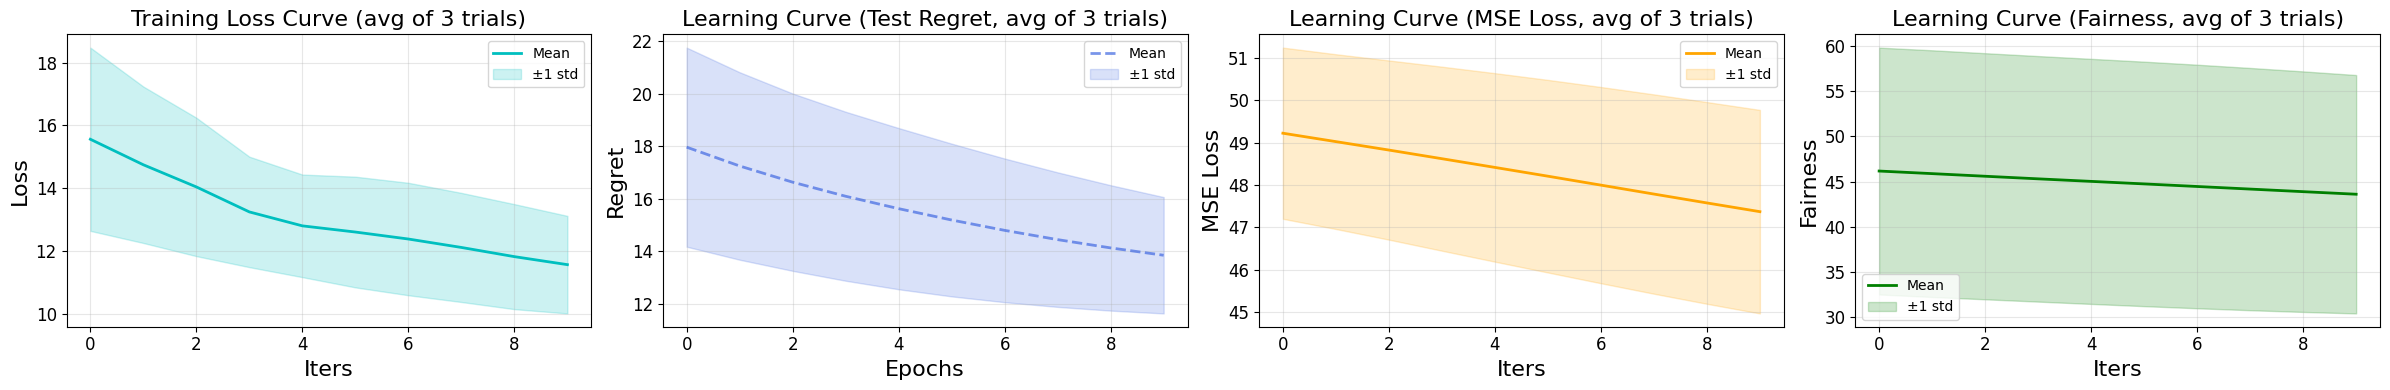


Running trial 1/3
Initial test regret: 14.4262

Running trial 2/3
Initial test regret: 17.0101

Running trial 3/3
Initial test regret: 17.3065

All trials completed in 1434.46 seconds
Mean trial time: 478.15 ± 12.92 seconds


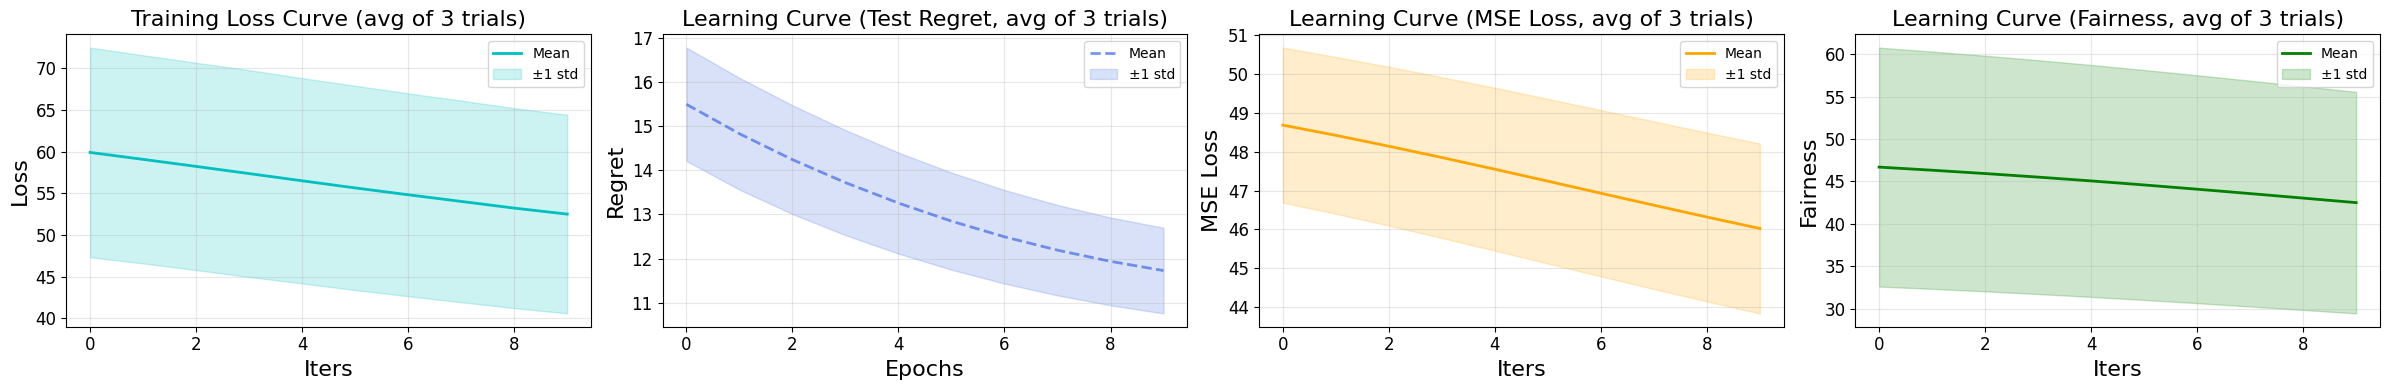

In [40]:
results_cvx_2 = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=0,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=2,
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)

results_cvx_2_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=1,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=2,
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)

save_results = {
    'results_cvx_2': results_cvx_2,
    'results_cvx_2_fair': results_cvx_2_fair
}

for name, data in save_results.items():
    with open(f'res/cvxpylayer/LR/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)



Running trial 1/3
Initial test regret: 0.9843

Running trial 2/3
Initial test regret: 0.9336

Running trial 3/3
Initial test regret: 0.9508

All trials completed in 1247.67 seconds
Mean trial time: 415.89 ± 121.71 seconds


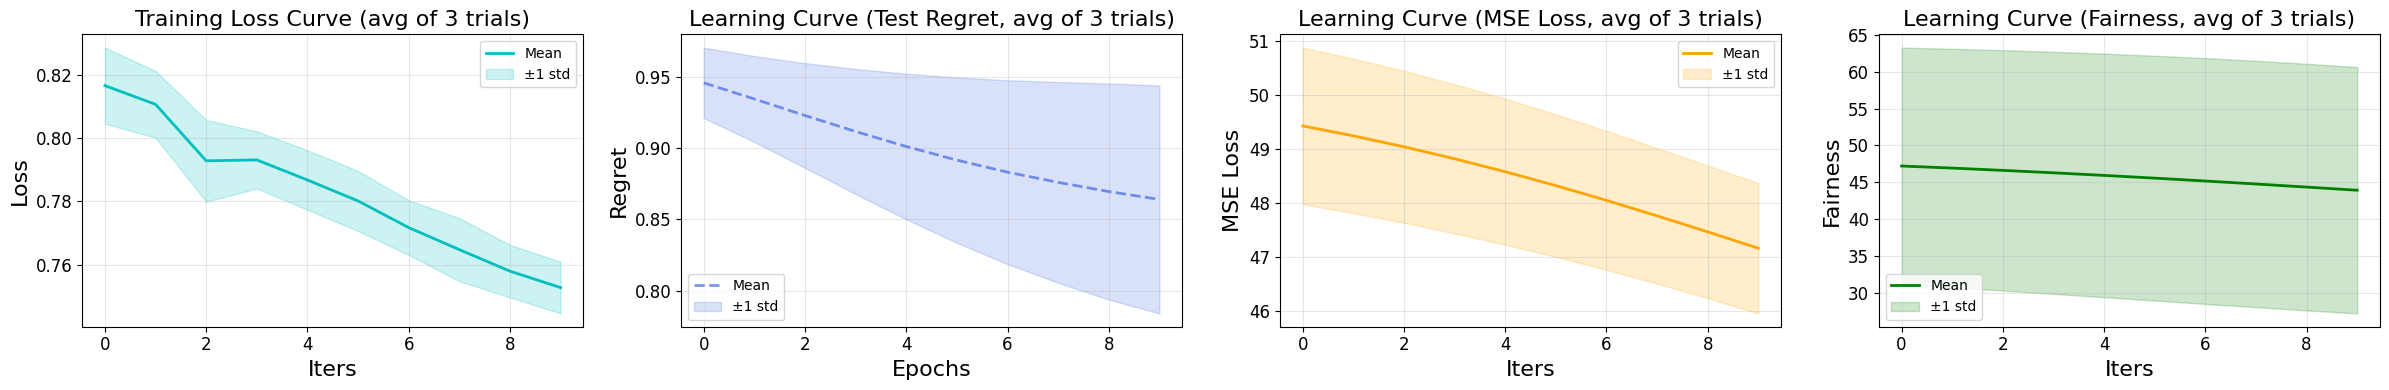


Running trial 1/3
Initial test regret: 0.9519

Running trial 2/3
Initial test regret: 0.9379

Running trial 3/3
Initial test regret: 0.8979

All trials completed in 1623.66 seconds
Mean trial time: 541.22 ± 143.85 seconds


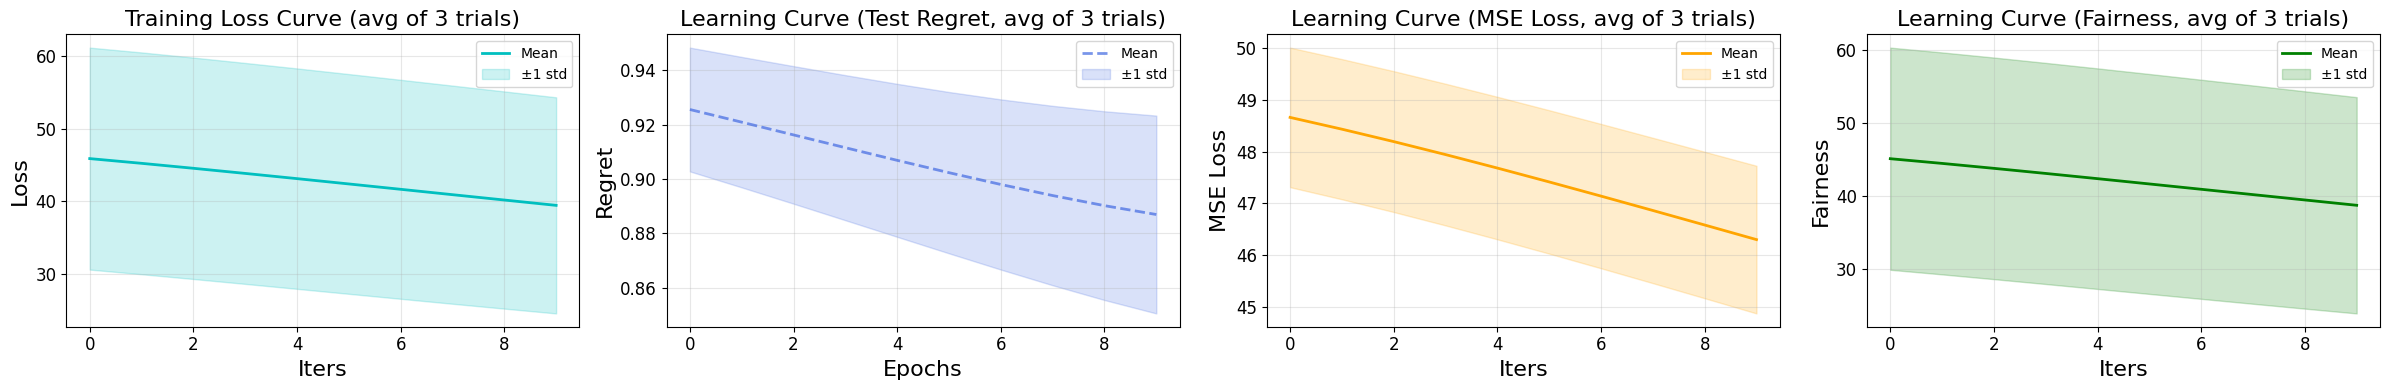

In [41]:

results_cvx_inf = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=0,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha='inf',
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)
results_cvx_inf_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=1,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha='inf',
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)


save_results = {
    'results_cvx_inf': results_cvx_inf,
    'results_cvx_inf_fair': results_cvx_inf_fair
}

for name, data in save_results.items():
    with open(f'res/cvxpylayer/LR/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)


Running trial 1/3
Initial test regret: 0.4558

Running trial 2/3
Initial test regret: 0.4548

Running trial 3/3
Initial test regret: 0.4864

All trials completed in 1355.69 seconds
Mean trial time: 451.90 ± 34.21 seconds


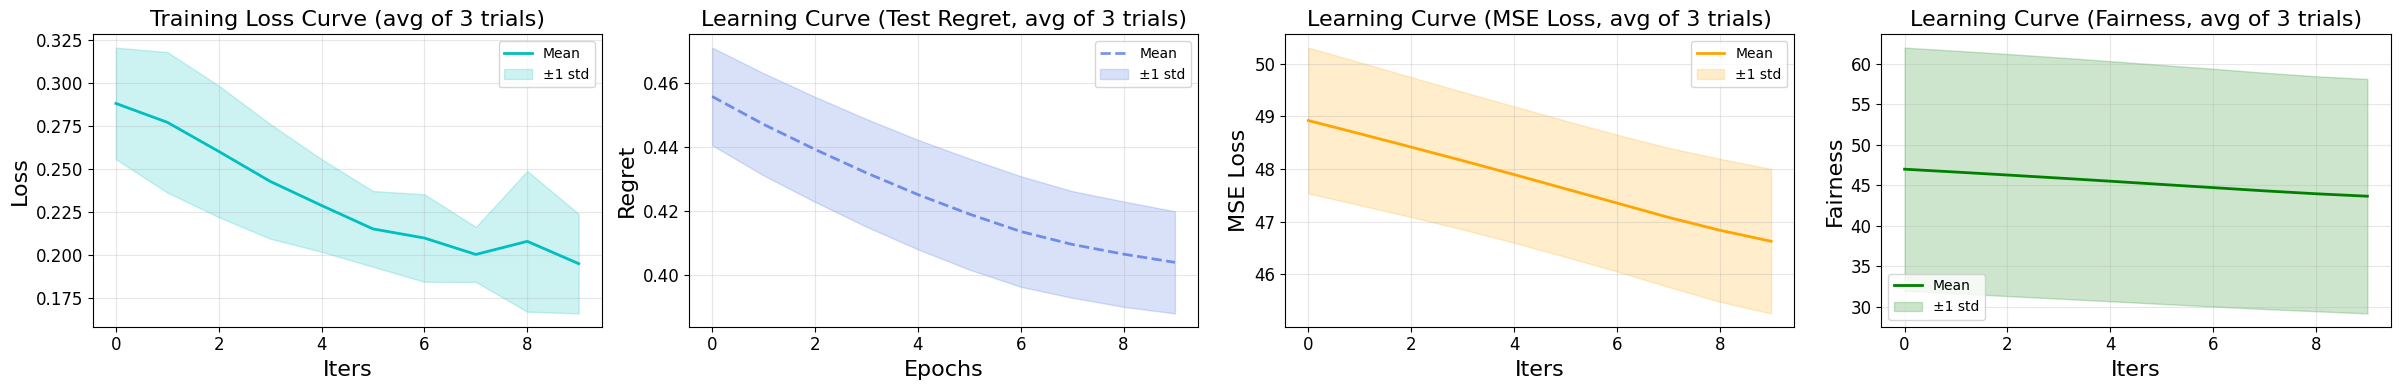


Running trial 1/3
Initial test regret: 0.4603

Running trial 2/3
Initial test regret: 0.5391

Running trial 3/3
Initial test regret: 0.4726

All trials completed in 1608.80 seconds
Mean trial time: 536.27 ± 89.91 seconds


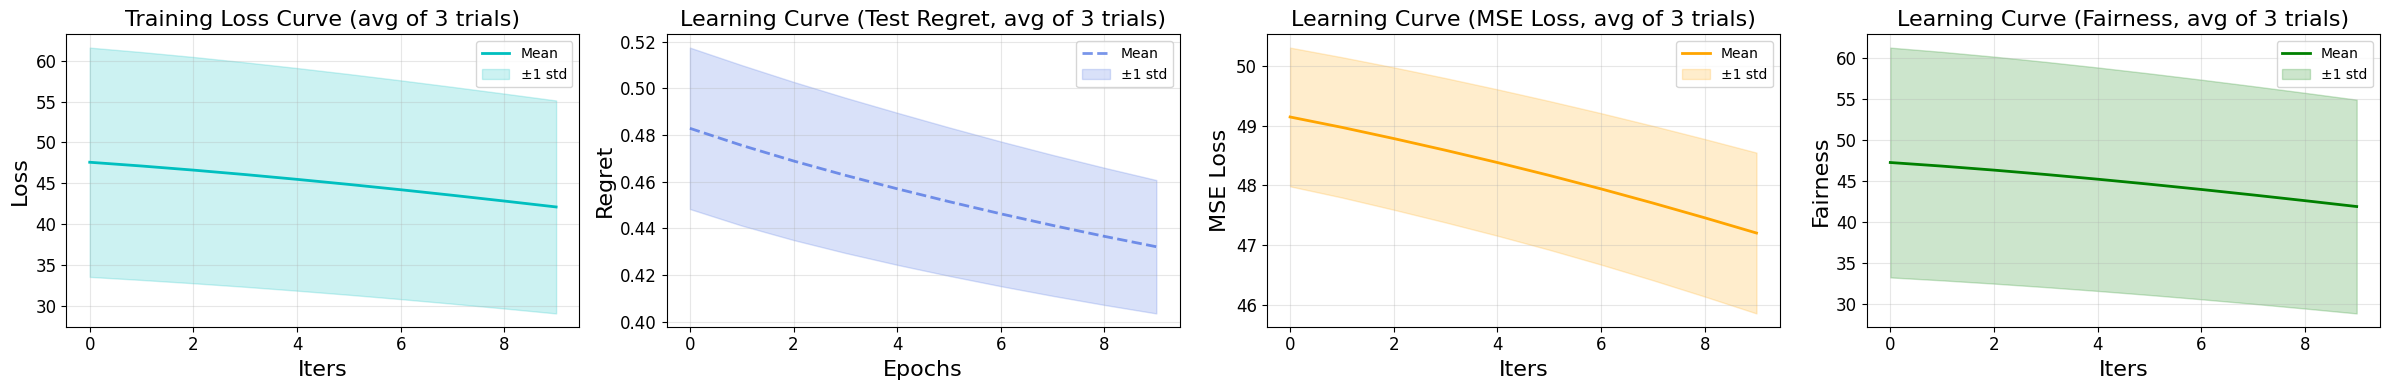

In [42]:

results_cvx_1p5 = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=0,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=1.5,
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)
results_cvx_1p5_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=1,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=1.5,
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)


save_results = {
    'results_cvx_1p5': results_cvx_1p5,
    'results_cvx_1p5_fair': results_cvx_1p5_fair
}

for name, data in save_results.items():
    with open(f'res/cvxpylayer/LR/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)


Running trial 1/3
Initial test regret: 0.1336

Running trial 2/3
Initial test regret: 0.0841

Running trial 3/3
Initial test regret: 0.1441

All trials completed in 2061.65 seconds
Mean trial time: 687.22 ± 74.61 seconds


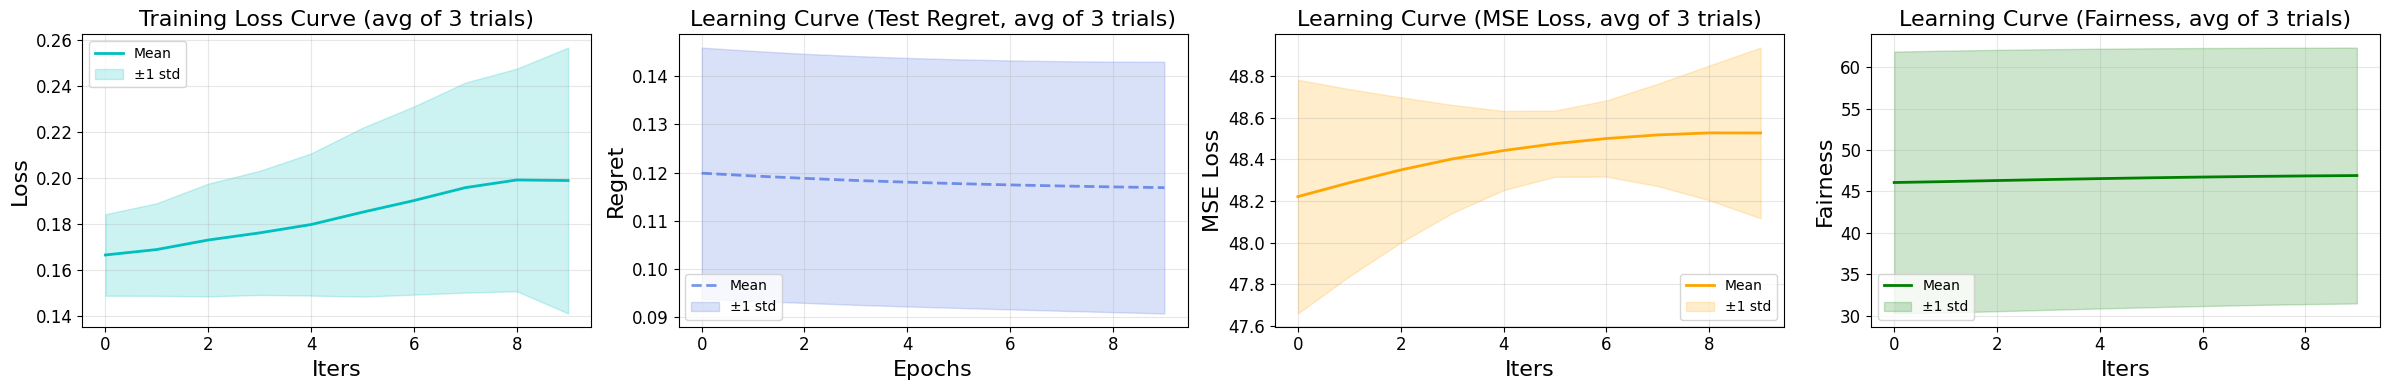


Running trial 1/3
Initial test regret: 0.1397

Running trial 2/3
Initial test regret: 0.0860

Running trial 3/3
Initial test regret: 0.1497

All trials completed in 1591.87 seconds
Mean trial time: 530.62 ± 116.91 seconds


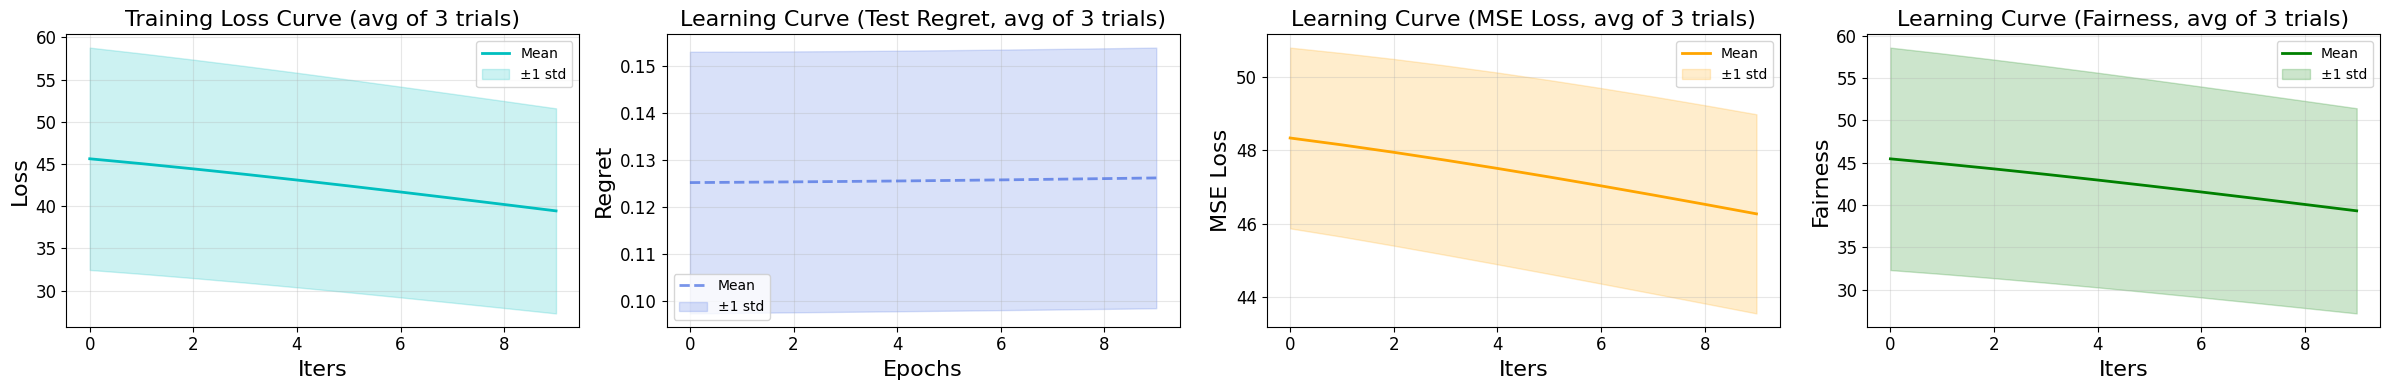

In [43]:

results_cvx_0p5 = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=0,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=0.5,
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)
results_cvx_0p5_fair = run_multiple_trials(
    optmodel=solve_closed_form,
    feats=feats,
    gainF=gainF,
    risk=risk,
    cost=cost,
    df=df,
    n_trials=3,
    lambda_fairness=1,
    num_epochs=10,
    initial_lr=2e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    scheduler_factor=0.5,
    min_lr=1e-4,
    alpha=0.5,
    Q=Q,
    dfl=True,
    grad_method='cvxpylayer'
)

save_results = {
    'results_cvx_0p5': results_cvx_0p5,
    'results_cvx_0p5_fair': results_cvx_0p5_fair
}
for name, data in save_results.items():
    with open(f'res/cvxpylayer/LR/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
raise Exception("Debugging complete.")

In [ ]:
raise ValueError("Training is not implemented in this code snippet.")

In [ ]:
import pickle

# List of dictionaries to store
dicts_to_store = {
    'results_pfl_no_fair': results_pfl_no_fair,
    'results_pfl_with_fair': results_pfl_with_fair,
    'results_dfl_no_fair': results_dfl_no_fair,
    'results_dfl_with_fair': results_dfl_with_fair,
    'results_dfl_with_fair_fin_diff_1': results_dfl_with_fair_fin_diff_1,
    'results_dfl_with_fair_fin_diff_2': results_dfl_with_fair_fin_diff_2,
    'time_results_findiff_solver': time_results_findiff_solver,
    'time_results_findiff_cf': time_results_findiff_cf
}

import os
# create dir if not exists
os.makedirs('res/alpha2-m2', exist_ok=True)

# Store dictionaries to local files
for name, data in dicts_to_store.items():
    with open(f'res/alpha2-m2/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

# Load dictionaries from local files
loaded_dicts = {}
for name in dicts_to_store.keys():
    with open(f'res/alpha2-m2/{name}.pkl', 'rb') as f:
        loaded_dicts[name] = pickle.load(f)

# Access loaded dictionaries
results_pfl_no_fair_loaded = loaded_dicts['results_pfl_no_fair']
results_pfl_with_fair_loaded = loaded_dicts['results_pfl_with_fair']
results_dfl_no_fair_loaded = loaded_dicts['results_dfl_no_fair']
results_dfl_with_fair_loaded = loaded_dicts['results_dfl_with_fair']
results_dfl_with_fair_fin_diff_1_loaded = loaded_dicts['results_dfl_with_fair_fin_diff_1']
results_dfl_with_fair_fin_diff_2_loaded = loaded_dicts['results_dfl_with_fair_fin_diff_2']
time_results_findiff_solver_loaded = loaded_dicts['time_results_findiff_solver']
time_results_findiff_cf_loaded = loaded_dicts['time_results_findiff_cf']